# ML challenge

As part of my ML practice, I was sent an ML challenge to develope a classifier that classfies pixels of hyperspectral images into various crops, which is an instance of a common problem known as crop mapping.

The satellite images in this instance are captured by the Sentinel-2 satellite.

[Sentinel-2](https://en.wikipedia.org/wiki/Sentinel-2) is an earth observation mission by the European Space Agency.

## Problem description

The following is the challenge description:

>You must implement a machine learning model to perform crop classification, and determine what crop types are grown where in an image of farm paddocks (also known as one-shot in-season crop classification). 

>Sentinel-2 is a satellite that captures 12 different wavelengths of light (also known as bands) in an image. These range from visible light (red, green, blue) to infra-red. The values for each band changes depending upon the material/object that is on the ground. 

## Provided code

In [1]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [2]:
def load_image(path):
    return np.array(PIL.Image.open(path))[:, :]

In [3]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

## Solution

After reading the problem description carefully, we start by loading the provided dataset

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay

In [7]:
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [8]:
DATA_FILE = "DATA/pixels.csv"
data = pd.read_csv(DATA_FILE)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299894 entries, 0 to 299893
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   B01         299894 non-null  float64
 1   B02         299894 non-null  float64
 2   B03         299894 non-null  float64
 3   B04         299894 non-null  float64
 4   B05         299894 non-null  float64
 5   B06         299894 non-null  float64
 6   B07         299894 non-null  float64
 7   B08         299894 non-null  float64
 8   B8A         299894 non-null  float64
 9   B09         299894 non-null  float64
 10  B11         299894 non-null  float64
 11  B12         299894 non-null  float64
 12  label_id    299894 non-null  int64  
 13  cloud_prob  299894 non-null  float64
 14  label       299894 non-null  object 
dtypes: float64(13), int64(1), object(1)
memory usage: 34.3+ MB


No null columns, thats good.

In [10]:
data['label_id'].unique()

array([1, 0, 2], dtype=int64)

There are 3 labels.

Let's check the label counts.

In [11]:
data.groupby(['label','label_id']).size()

label    label_id
Cotton   2            11087
Other    0           275350
Sorghum  1            13457
dtype: int64

In [12]:
labels2ids = {'Other' : 0 , 'Sorghum':1, 'Cotton':2}
ids2labels = {value:key for key,value in labels2ids.items()}

The labels are imbalanced.

Let's remove rows with cloud probability greater than 2 and check the counts again

In [13]:
data_no_clouds = data[data['cloud_prob']<=2]
"with clouds: " + str(len(data)), "without clouds: " + str(len(data_no_clouds))

('with clouds: 299894', 'without clouds: 297351')

In [14]:
data_no_clouds.groupby(['label','label_id']).size()

label    label_id
Cotton   2            11087
Other    0           272879
Sorghum  1            13385
dtype: int64

Let's check the data ranges of features.



In [15]:
data_no_clouds.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,label_id,cloud_prob
count,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000,297351.000000
mean,0.061849,0.076644,0.097624,0.109417,0.139290,0.193856,0.217530,0.226073,0.235409,0.249065,0.255259,0.204514,0.119586,0.041271
std,0.026723,0.029300,0.031394,0.046590,0.040789,0.060590,0.084279,0.085944,0.087007,0.095317,0.077941,0.085845,0.424096,0.234945
min,0.005600,0.005500,0.008900,0.007200,0.014600,0.036000,0.045900,0.044500,0.050200,0.044700,0.024500,0.019300,0.000000,0.000000
25%,0.048600,0.061100,0.079700,0.080000,0.115600,0.157400,0.170000,0.177600,0.186900,0.189800,0.206000,0.135400,0.000000,0.000000
50%,0.060800,0.074900,0.098000,0.105200,0.139900,0.188700,0.203800,0.213800,0.222500,0.225300,0.247500,0.210300,0.000000,0.000000
75%,0.077300,0.096900,0.118000,0.147800,0.167300,0.231300,0.257900,0.266400,0.277400,0.293550,0.320500,0.283300,0.000000,0.000000
max,0.519100,0.460400,0.401200,0.570000,0.585900,0.573100,0.603300,0.617200,0.626500,1.002700,0.555100,0.532600,2.000000,2.000000


array([[<AxesSubplot:title={'center':'B01'}>],
       [<AxesSubplot:title={'center':'B02'}>],
       [<AxesSubplot:title={'center':'B03'}>],
       [<AxesSubplot:title={'center':'B04'}>],
       [<AxesSubplot:title={'center':'B05'}>],
       [<AxesSubplot:title={'center':'B06'}>],
       [<AxesSubplot:title={'center':'B07'}>],
       [<AxesSubplot:title={'center':'B08'}>],
       [<AxesSubplot:title={'center':'B8A'}>],
       [<AxesSubplot:title={'center':'B09'}>],
       [<AxesSubplot:title={'center':'B11'}>],
       [<AxesSubplot:title={'center':'B12'}>],
       [<AxesSubplot:>],
       [<AxesSubplot:>]], dtype=object)

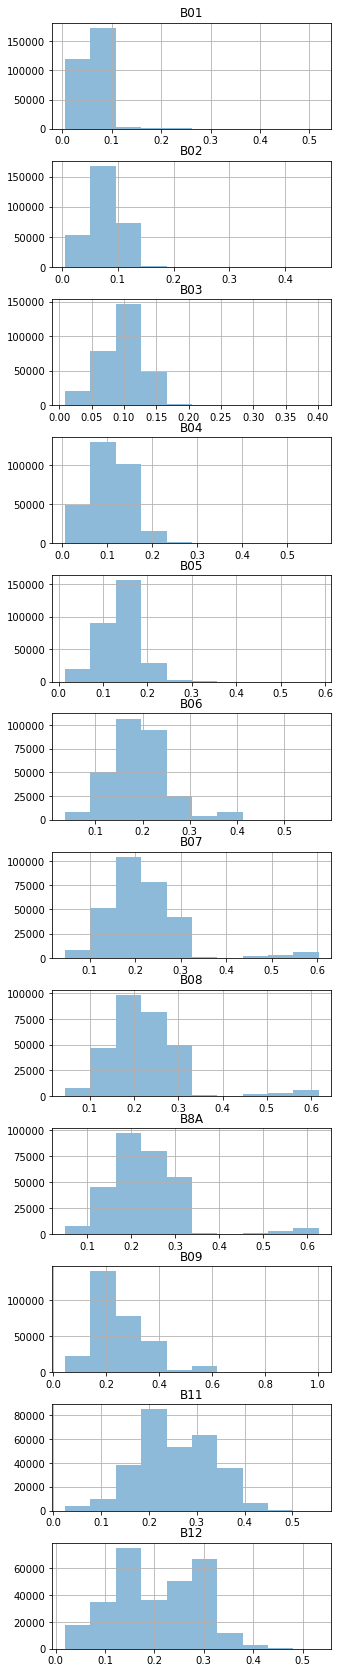

In [16]:
data_no_clouds[bands].hist(figsize=(5 , 35), bins=10, alpha=0.5, layout=(14,1))

### 3. Mean values and +-2 standard deviations of all the bands per crop

#### 3.1 Other

To plot the $∓2σ$ standard deviations, we can plot box plots with the whiskers of the boxes at the $∓2σ$ by setting the whiskers to the percentiles 2.28, 97.72
[Source](https://en.wikipedia.org/wiki/Percentile)

In [17]:
def plot_means_and_stds(data):
  ax, bp = data[bands].boxplot(whis=[2.28, 97.72], vert=False, showmeans=True, figsize=(15,15), return_type="both")
  means = data[bands].mean(axis=0)
  stds = data[bands].std(axis=0)
  for i, line in enumerate(bp['medians']):
      x, y = line.get_xydata()[1]
      text = '-2σ={:.2f}, μ={:.2f}, +2σ={:.2f}'.format(means[i]-2*stds[i], means[i], means[i]+2*stds[i])
      ax.annotate(text, xy=(max(0, x-0.07), y+0.07))
  ax.set_xlim(0, 1.1)

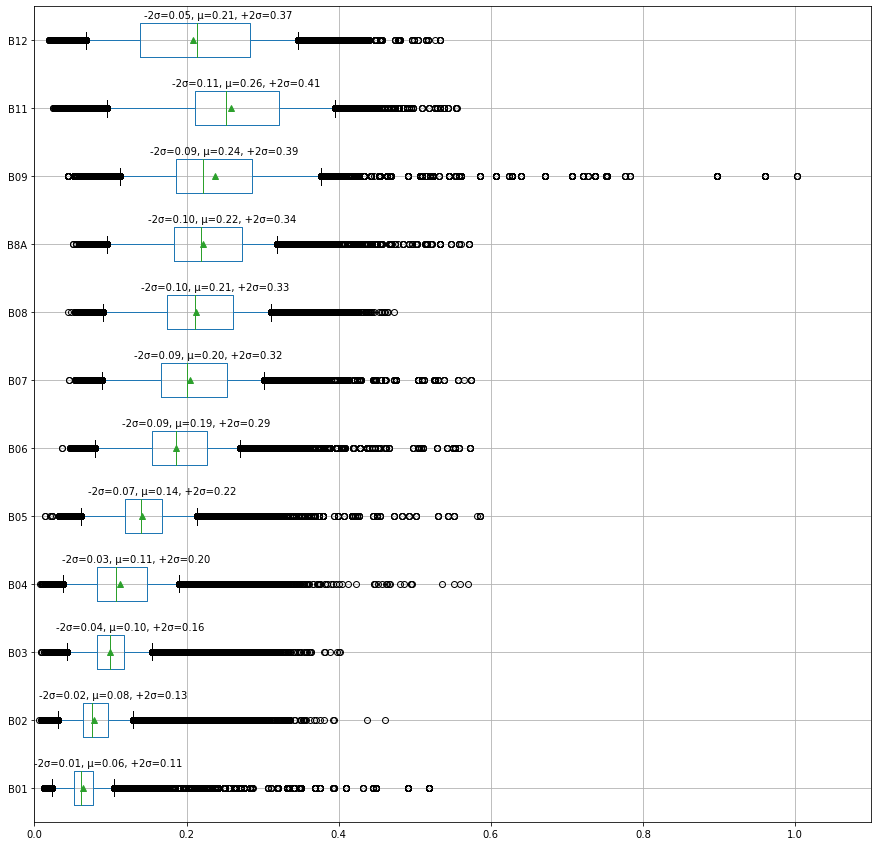

In [18]:
data_other = data_no_clouds[data_no_clouds['label'] == 'Other']
plot_means_and_stds(data_other)

#### 3.2 Sorghum

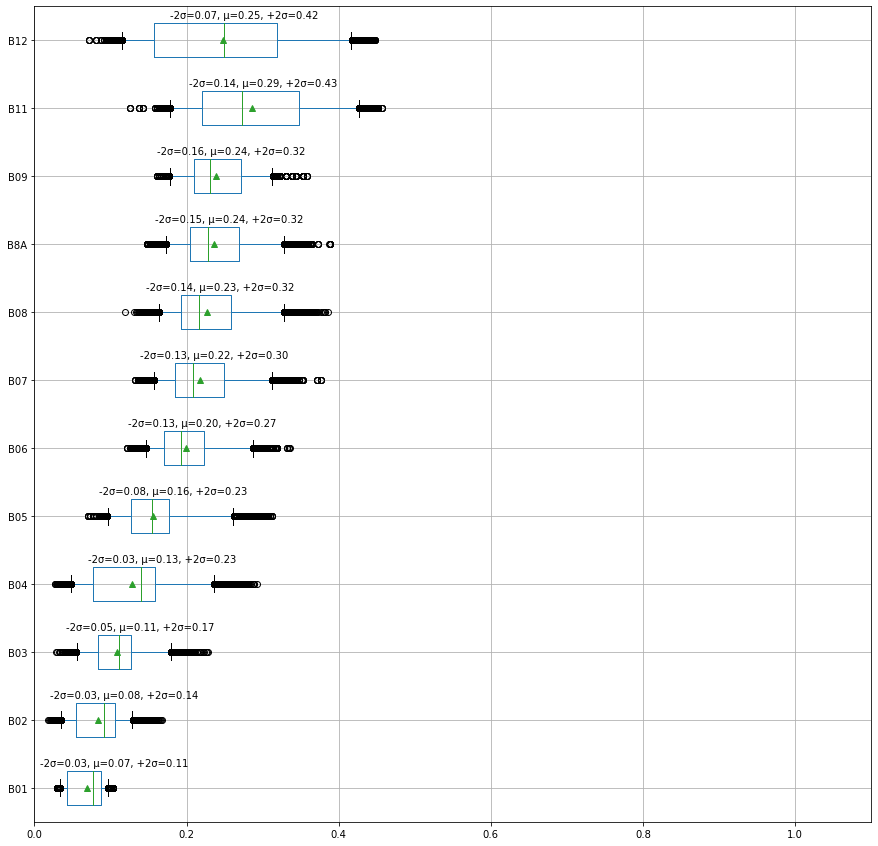

In [19]:
data_sorghum = data_no_clouds[data_no_clouds['label'] == 'Sorghum']
plot_means_and_stds(data_sorghum)

#### 3.3 Cotton

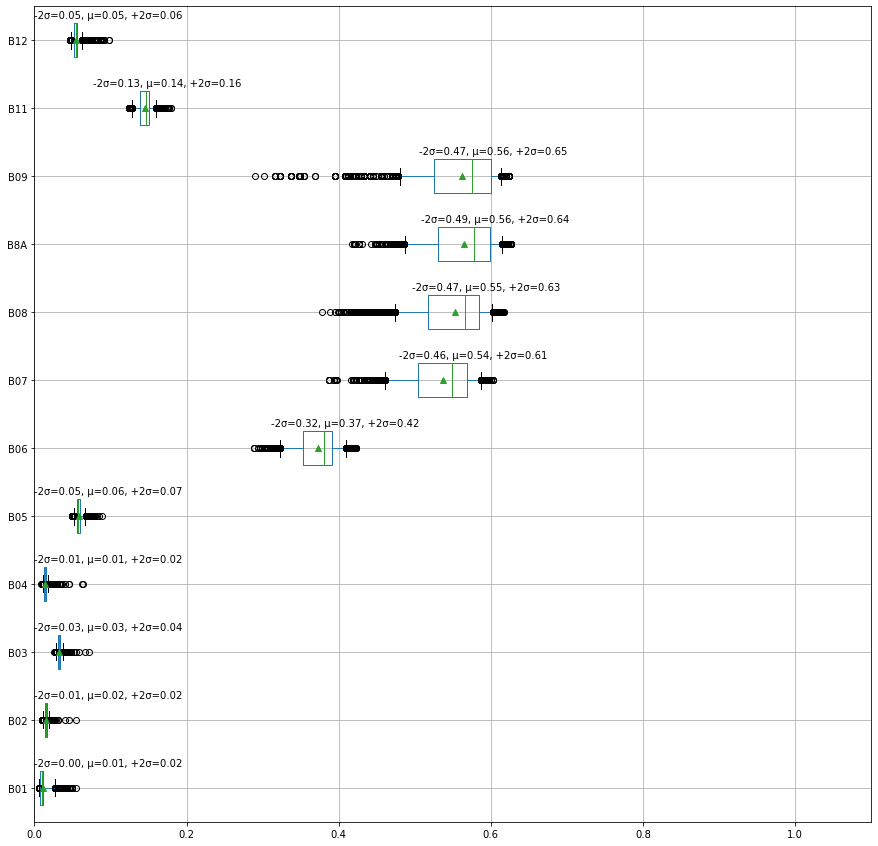

In [20]:
data_cotton = data_no_clouds[data_no_clouds['label'] == 'Cotton']
plot_means_and_stds(data_cotton)

This figure is promising as the values in the bands B6-B9 seem to be distinguishing features for the cotton crop. 

### 4. Machine learning model training



#### Step 1: Baseline model: Multiclass Logistic Regression

The first model I am going to try is the multiclass logistic regression for it's simplicity to get an idea about the possible accuracy.

In [21]:
def train_test_assess(data, model):
    X = data[data.columns[~data.columns.isin(['label_id', 'label', 'cloud_prob'])]]
    y = data['label_id']
    labels = [ids2labels[id] for id in sorted(data['label_id'].unique().tolist())]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print('Accuracy: {:.2f}%'.format(accuracy_score(y_predicted, y_test)*100 ))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=labels)
    # if binary classification, report the AUC metric
    if len(labels) == 2:
        fpr, tpr, thresholds = roc_curve(y_test==1, y_predicted==1, pos_label=1)
        print('AUC: {:.2f}'.format(auc(fpr, tpr)))
    return model

Accuracy: 95.48%


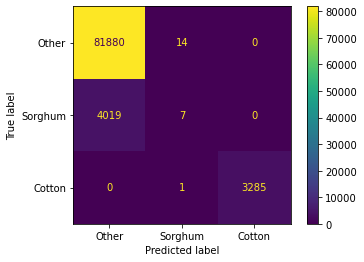

In [22]:
clf = LogisticRegression(max_iter=10000, multi_class='multinomial')
clf = train_test_assess(data_no_clouds, clf)

This initial result is consistent with our initial intuition, *Cotton* is easier classify than *Other* and *Sorghum*.

It might a good idea to search the literature at this point for discriminative features.

I'm going to attempt to try to focus on the *Sorghum* vs *Other* problem next.

#### Step 2: Binary classification (*Sorghum* vs *Other*)

In [23]:
data_bin = data_no_clouds[~data_no_clouds['label'].isin(['Cotton'])]

In [24]:
data_bin['label'].value_counts()/data_bin.shape[0] * 100

Other      95.324246
Sorghum     4.675754
Name: label, dtype: float64

The data is highly imbalanced, as a first attempt to fix that, let's try to add weights.

#### Step 3: Binary classification with Random Forest

#### Step 3.1: Binary classification with Random Forest and Remote Sensing 
Next, we test the benefit of adding NDVI and NDWI indices

NDVI: The normalized difference vegetation index, an effective index for quantifying green vegetation.

NDWI: The normalized difference water index used to monitor changes related to water content in water bodies.

NDMI: The normalized difference moisture index used to monitor changes in water content of leaves.

For a full list of remote sensing indices https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/

In [25]:
data_bin_aug = data_bin.copy()

# Calculate NDVI according to https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
data_bin_aug['NDVI'] = (data_bin['B08'] - data_bin['B04'])/(data_bin['B08'] + data_bin['B04'])
# Calculate NDWI according to https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/
data_bin_aug['NDWI'] = (data_bin['B03'] - data_bin['B08'])/(data_bin['B03'] + data_bin['B08'])
# Calculate NDMI according to https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndmi/
data_bin_aug['NDMI'] = (data_bin['B08'] - data_bin['B11'])/(data_bin['B08'] + data_bin['B11'])
# Calculate NDMI according to https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/gndvi/#
data_bin_aug['GNDVI'] = (data_bin['B08'] - data_bin['B03'])/(data_bin['B08'] + data_bin['B03'])

# source : https://eprints.lancs.ac.uk/id/eprint/136586/2/Author_Accepted_Manuscript.pdf
data_bin_aug['GCVI'] = (data_bin['B8A'] / data_bin['B03']) - 1
data_bin_aug['SR'] = data_bin['B8A'] / data_bin['B04']
data_bin_aug['WDRVI'] = (0.2*data_bin['B8A'] - data_bin['B04'])/(0.2*data_bin['B8A'] + data_bin['B04'])

#### Step 4: Random under- and over-sampling

To solve the data imbalance issue, let's use resampling techinques. 

First we are going to start by under-sampling, that is to randomly pick samples from the majority group such that the majority and minority classes become of the same size.

In [26]:
# Features importances
def calc_feats_importances(model, data):
    imps = list(model.feature_importances_/sum(model.feature_importances_) * 100)
    feats = data.columns[~data.columns.isin(['label_id', 'label', 'cloud_prob'])]
    feats_imps = dict(zip(feats, imps))
    return feats_imps

**Undersampling**

Class distribution: 
Other      272879
Sorghum     13385
Name: label, dtype: int64
Accuracy: 93.74%
AUC: 0.96


{'B01': 16.977792737026085,
 'B02': 6.752882418570922,
 'B03': 2.554969210163749,
 'B04': 2.6563337118232186,
 'B05': 3.3259631537606507,
 'B06': 3.9223474314521467,
 'B07': 3.8106562700819713,
 'B08': 3.5390293533814705,
 'B8A': 4.125422731372653,
 'B09': 11.247041256299674,
 'B11': 6.183133344698969,
 'B12': 8.360377618059259,
 'NDVI': 3.579062573810352,
 'NDWI': 4.239217235594501,
 'NDMI': 4.276727881317791,
 'GNDVI': 4.767229788099875,
 'GCVI': 3.348787865016853,
 'SR': 3.351913622009852,
 'WDRVI': 2.9811117974600068}

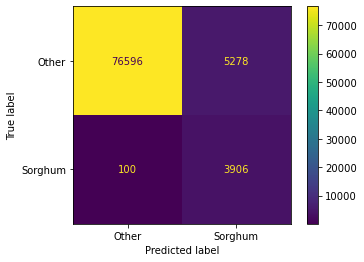

In [27]:
# Class count
print('Class distribution: \n'+str(data_bin['label'].value_counts()))

clf_bin5 = make_pipeline_with_sampler(
    RandomUnderSampler(),
    RandomForestClassifier(),
)

clf_bin5 = train_test_assess(data_bin_aug, clf_bin5)
calc_feats_importances(clf_bin5[1], data_bin_aug)

Since features B03, B04, B05, B07, B08 seem to have the least effect, let's try removing them

Accuracy: 93.56%
AUC: 0.95


{'B01': 18.12897209994457,
 'B02': 7.237858677151985,
 'B06': 6.580060537808315,
 'B8A': 6.095497050380915,
 'B09': 12.43070752907386,
 'B11': 8.321135912566861,
 'B12': 9.327024620656,
 'NDVI': 4.785401272622748,
 'NDWI': 4.975197715869764,
 'NDMI': 5.109331237453354,
 'GNDVI': 5.734742204540842,
 'GCVI': 4.490255452417144,
 'SR': 3.3861633080797793,
 'WDRVI': 3.3976523814338675}

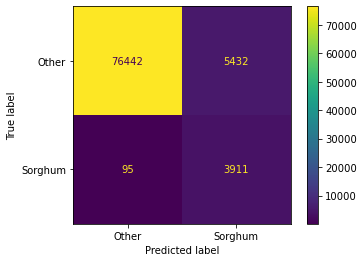

In [28]:
# Class count
clf_bin6 = make_pipeline_with_sampler(
    RandomUnderSampler(),
    RandomForestClassifier(),
)
# remove the less important features
data_bin_imp = data_bin_aug.copy()
data_bin_imp = data_bin_imp[data_bin_imp.columns[~data_bin_imp.columns.isin(['B03', 'B04', 'B05', 'B07' ,'B08'])]]

clf_bin6 = train_test_assess(data_bin_imp, clf_bin6)
calc_feats_importances(clf_bin6[1], data_bin_imp)

Next, I will test the accuracy on the full data (including Sorghum)

Accuracy: 94.46%


{'B01': 9.6464853828485,
 'B02': 9.714544169136957,
 'B03': 2.7639361993439553,
 'B04': 8.411027820590892,
 'B05': 2.6418393007109287,
 'B06': 4.068313242872104,
 'B07': 12.051608284154835,
 'B08': 18.782597265383384,
 'B8A': 12.360924465779007,
 'B09': 8.479810816147658,
 'B11': 4.532715522991699,
 'B12': 6.546197530040068}

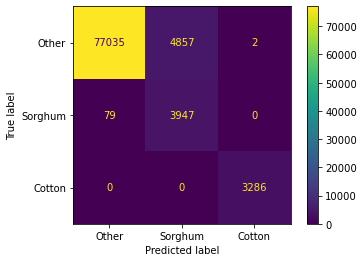

In [29]:
clf8 = make_pipeline_with_sampler(
    RandomUnderSampler(),
    RandomForestClassifier(),
)

clf8 = train_test_assess(data_no_clouds, clf8)
calc_feats_importances(clf8[1], data_no_clouds)

I am going to pick the model with RandomDownSampler as it gives satisfactory results for the current data, the next step is a feature selection process.

In [30]:
X = data_bin_aug[data_bin_aug.columns[~data_bin_aug.columns.isin(['label_id', 'label', 'cloud_prob'])]]
y = data_bin_aug['label_id']

In [31]:
# source: https://imbalanced-learn.org/stable/under_sampling.html
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

print(sorted(Counter(y).items()))
cc = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

[(0, 272879), (1, 13385)]
[(0, 13385), (1, 13385)]


Next, we perform feature selection to find the most important features.

Optimal number of features : 2


C:\Users\user\anaconda3\envs\ml-challenge-env\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


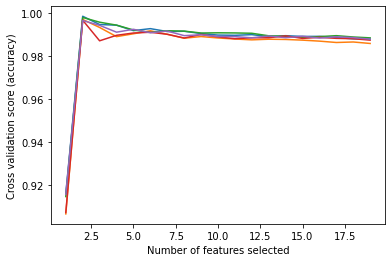

In [32]:
# source: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
svc = RandomForestClassifier()

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [33]:
rfecv.get_feature_names_out()

array(['B01', 'B09'], dtype=object)

Accuracy: 97.59%


{'B01': 50.180496359837235, 'B09': 49.819503640162765}

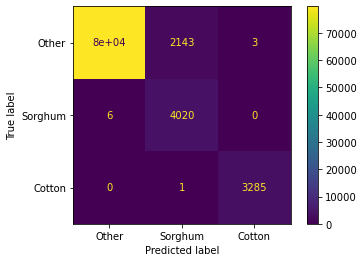

In [34]:
clf9 = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0),
    RandomForestClassifier(),
)
features = ['B01', 'B09']
clf9 = train_test_assess(data_no_clouds[features + ['label_id']], clf9)
calc_feats_importances(clf9[1], data_no_clouds[features])

### 6. Satellite images 
Now that we have trained a model, let's try to apply it to the images provided

In [35]:
def load_images(paths, mask_path=None):
    
    df = pd.DataFrame()
    
    for path in paths:
        img = load_image(path)/10000
        img = img.flatten()
        df[path.split('.')[0].split('/')[1]] = img
    
    mask = load_image(mask_path)/255
    mask = np.mean(mask, -1)
    mask = mask.flatten() > 0
    df['mask'] = mask
    
    return df

In [36]:
imgs = ['data/' + band +'.tif' for band in bands]
sat_imgs = load_images(imgs, mask_path='data/mask.png')

In [37]:
def predict_label_image(model, images_df, bands, output_fname='predicted.png'):
    # initialize pred_label column to 10 (a non valid label)
    images_df.loc[:, 'pred_label'] = 10
    # limit the prediction to the pixels where the mask is true
    images_df.loc[images_df['mask'] == True, 'pred_label'] = model.predict(images_df.loc[images_df['mask'] == True, bands])
    # create RGB predicted label image
    images_df.loc[:,'R'] = 0
    images_df.loc[:,'G'] = 0
    images_df.loc[:,'B'] = 0

    # when the predicted label is 0 (Other) set the value of pixel RED
    images_df.loc[images_df['pred_label'] == 0, 'R'] = 255
    # when the predicted label is 1 (Sorghum) set the value of pixel GREEN
    images_df.loc[images_df['pred_label'] == 1, 'G'] = 255
    # when the predicted label is 2 (Cotton) set the value of pixel BLUE
    images_df.loc[images_df['pred_label'] == 2, 'B'] = 255

    chans = ['R', 'G', 'B']
    dims = (4000, 4000)
    rgb_label = np.zeros(dims + (3, ), 'uint8')

    for idx, chan in enumerate(chans):
        img = images_df[chan].to_numpy()
        rgb_label[..., idx] = img.reshape(dims)
    
    img = PIL.Image.fromarray(rgb_label)
    img.save(output_fname)

    return rgb_label

In [38]:
features = ['B01', 'B09']
rgb_label = predict_label_image(clf9, sat_imgs.loc[:, features + ['mask']], features)

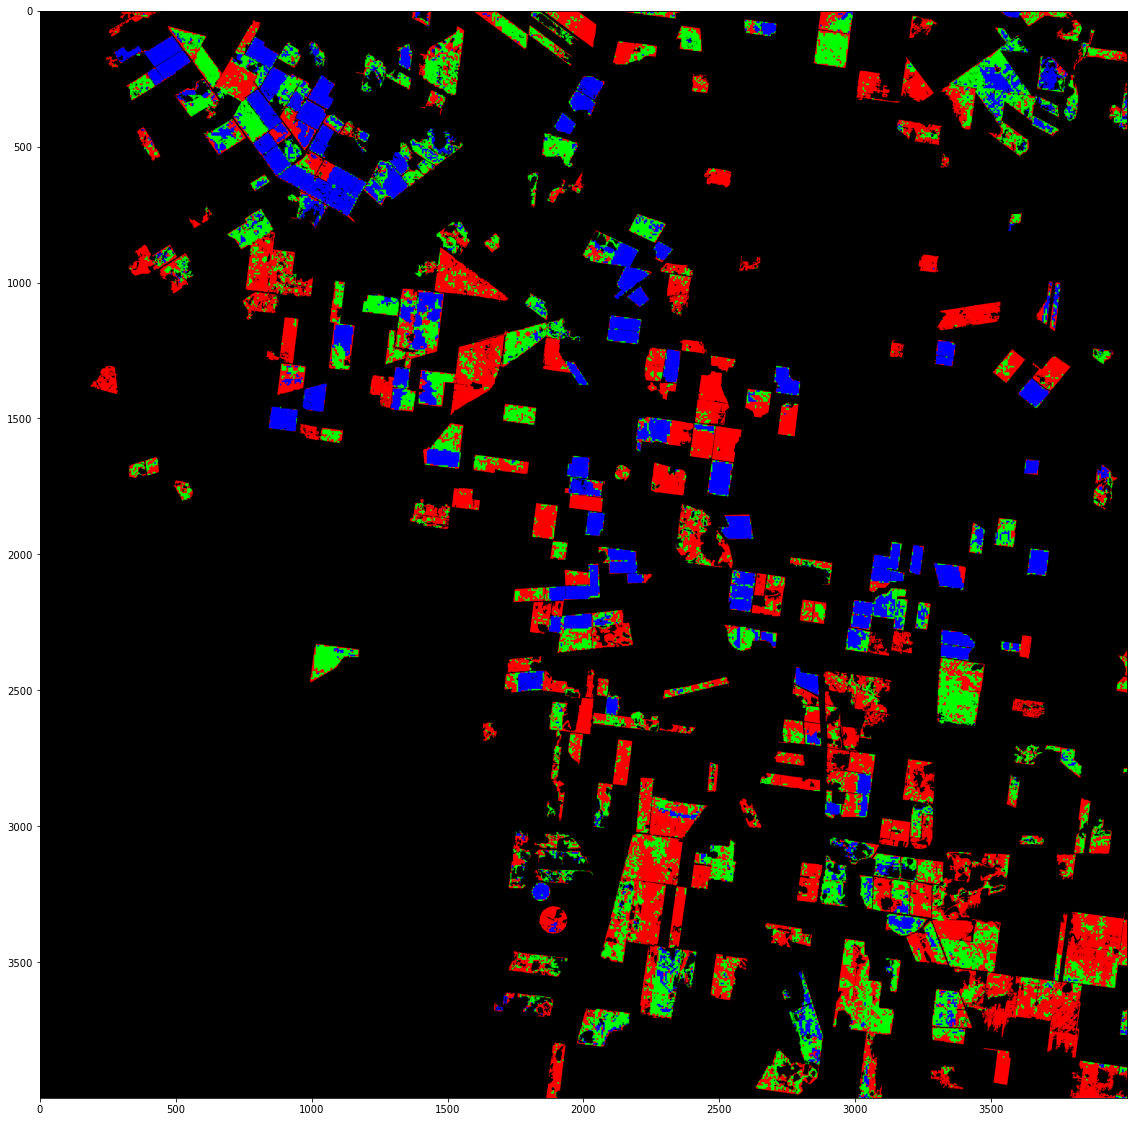

In [39]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.imshow(rgb_label )

Reminder: 
* Red is Other
* Green is Sorghum
* Blue is Cotton

Observations: 
* Many paddocks' predictions are noisy, especially for Sorghum and Other. 
* The boundary of the Cotton Paddocks are always mispredicted.

Data and training observation:
* The training data is highly imbalanced
* Using weights for the classifier is not the best option
* The generated features (NDVI and NDWI) are not discriminative


Next steps:
* In the current experiment, we built a pixel classifier. We can build a patch level classifier as a next step, which can potentially reduce the class noise we are seeing in the earlier label image because it would provide more context to the classifier compared to the pixel level classifier.
* Another potential solution to the class noise issue is to introduce more discriminative features by exploring various feature combinations as well as generating new features.
* Improving the quality of the training data by introducing a QA process to the data labelling. The QA process could involving relying on other data sources other than satellite images.
* Hyperparameter tuning can be performed using cross validation and grid search methods as a next step to further improve the model performance (https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).


## Resources

* [Imbalanced data](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
* [Satellite image deep learning repo](https://github.com/robmarkcole/satellite-image-deep-learning)